Projet Réseaux de neurones TAL M2 IM
- Reconnaissances des langues peu annotées
- Membre du groupe : Siyu WANG, Shuai GAO et Chen SUN

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import glob
import cv2
import numpy as np
import os
import random
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt


class dataSetImg:
  
  def __init__(self):
    self.data = {"train":[], "test":[]}
    self.labels = {"train":[], "test":[]}
    self.size = 0
    
    
  def load_data(self, root, dicoLocs, dimsize=(28, 28)):
    """Place les images dans le dataset sous forme de array."""
    
    self.name_label = dicoLocs
    print("Load data...")
    for type_data in ["train","test"]:
      for loc in self.name_label:
        #print(type_data)
        for path_file in glob.glob(os.path.join(root, type_data, loc, "*.png")):
          print(path_file)
          img = cv2.imread(path_file, 0).astype(np.uint8)
          res = cv2.resize(img, dsize=dimsize)
          res = img_to_array(res)
          self.data[type_data].append(res)
          self.labels[type_data].append(self.name_label[loc])
          self.size += 1
    print("Loading : OK")
    
    
      
  def import_data(self, resplit_test=False,
                 labels_to_categorical=True,
                 verbose=False):
    """Importe les données du dataset en les formatant.
    Vous pouvez redéfinir la taille des données de test.
    Le dataset n'est pas modifié."""
    
    def to_array(*args_list):
      convert = lambda x: np.array(x)
      return map(convert, args_list)
    
    def to_format(x):
      x = np.array(x)
      x = x.reshape(-1, x.shape[1], x.shape[2], 1)
      x = x.astype('float32')
      x /= 255.
      return x
    
    def shuffle(l1, l2):
      data_zip = [*zip(l1, l2)]
      random.shuffle(data_zip)
      l1, l2 = [], []
      for ele1, ele2 in data_zip:
        l1.append(ele1)
        l2.append(ele2)
      return l1, l2
    
    if resplit_test:
      data = self.data["train"] + self.data["test"]
      labels = self.labels["train"] + self.labels["test"]
      data, labels = shuffle(data, labels)
      n = int(resplit_test*self.size)
      data_train, data_test = data[n:], data[:n]
      labels_train, labels_test = labels[n:], labels[:n]                      
    else:
      data_train, labels_train = shuffle(self.data["train"], self.labels["train"])
      data_test, labels_test = shuffle(self.data["test"], self.labels["test"])
      
    if labels_to_categorical:
      labels_train = to_categorical(labels_train)
      labels_test = to_categorical(labels_test)
      
    data_train, data_test, labels_train, labels_test = to_array(data_train,
                                                               data_test,
                                                               labels_train,
                                                               labels_test)
    data_train, data_test = to_format(data_train), to_format(data_test)
    
    
    if verbose :
      print(f"Total : {self.size}\
      Size train : {len(data_train)}, shape : {data_train.shape}\
      Size test : {len(data_test)},  shape : {data_test.shape}")
    return data_train, data_test, labels_train, labels_test
     

In [0]:
root = "gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/"
dicoLocs = {'chinois':0, 'tatar':1,'mongol':2, 'estonien':3}

dataset = dataSetImg()
dataset.load_data(root, dicoLocs)

Load data...
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18877899_sans_silence.wavchunk1.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18651262_sans_silence.wavchunk0.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18536106_sans_silence.wavchunk1.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18688782_sans_silence.wavchunk0.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18771581_sans_silence.wavchunk1.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18718067_sans_silence.wavchunk0.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18732195_sans_silence.wavchunk0.png
gdrive/My Drive/ReseauxNeuronnes/spectro_corpus_valide/train/chinois/common_voice_zh-CN_18836320_sans_silence.wavchunk2

In [0]:
data_train, data_test, labels_train, labels_test = dataset.import_data(resplit_test=False,
                                                                      labels_to_categorical = True,
                                                                      verbose = True)

Total : 17127      Size train : 16727, shape : (16727, 28, 28, 1)      Size test : 400,  shape : (400, 28, 28, 1)


In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta
from keras.models import load_model


model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu',
          input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), # (2,2) originally
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dropout(0.25),
    layers.Dense(689, activation="relu"),
    layers.Dense(4, activation="softmax")   
])
model.summary()

learning_rate = 0.01
nb_epoch = 100

optimizer = optimizers.SGD(lr=learning_rate, decay=learning_rate/nb_epoch, momentum=0.9, nesterov=True)
#optimizer = Adadelta()
#optimizer = "adam"

model.compile( loss = "categorical_crossentropy", 
               optimizer = optimizer, 
               metrics=['accuracy']
             )

stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     save_best_only=True)
history = model.fit(data_train, labels_train, validation_split=0.2,
                    batch_size=50,
                    epochs=100,
                    verbose=1,
                    callbacks=[stop,mc])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 689)               1103089   
_________________________________________________________________
dense_54 (Dense)             (None, 4)               

history
400/400 [==============================] - 1s 1ms/step

Best epoch for the val_loss is :  14

Best epoch for the val_acc is :  39


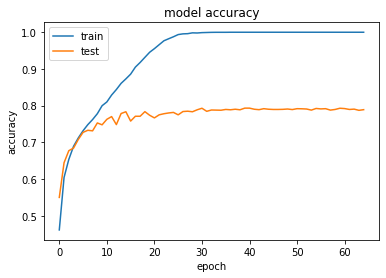

In [0]:
import matplotlib.pyplot as plt
print("history")

# Result on test data with BEST model
best_model = load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(data_test, labels_test)
val_loss_list = history.history["val_loss"]
best_val_loss_epoch = val_loss_list.index(min(val_loss_list))

val_acc_list = history.history["val_acc"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

#print(f"Test accuraccy : {test_acc}")
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()